In [2]:
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from shapely import wkt
from shapely.geometry import Point, Polygon
import geopandas as gpd
# import rtree, pygeos, fiona
# import netCDF4
import xarray as xr
# import dask

/Users/etriesch/.pyenv/versions/venv.ocean-carbon-sampling/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
repo_path = Path('/Users/etriesch/dev/ocean-carbon-sampling/')
write_path = repo_path / 'data/clean/'
crs = 'epsg:4326'

In [4]:
# Northeast Pacific mask
p_min_lat, p_max_lat = 29, 48
# p_min_lon, p_max_lon = 360-140, 360-116 
p_min_lon, p_max_lon = -140, -116 
#Northwest Atlantic mask
a_min_lat, a_max_lat = 20, 48
a_min_lon, a_max_lon = -97, -60

# Read in data

In [6]:
# get filenames
temp_path = repo_path / 'data/raw/oisst/'
t_files = [f for f in os.listdir(temp_path) 
           if f.endswith('.nc')]
t_files.sort()
print('files to read:', len(t_files))

files to read: 120


In [8]:
# read in data
t_pac = pd.DataFrame()
t_atl = pd.DataFrame()
for f in tqdm(t_files):
    t = xr.open_dataset(temp_path / f)
    # create pacific and atlantic masks
    t['lon'] = t.lon - 360
    p_mask_lon = (t.lon >= p_min_lon) & (t.lon <= p_max_lon)
    p_mask_lat = (t.lat >= p_min_lat) & (t.lat <= p_max_lat)
    a_mask_lon = (t.lon >= a_min_lon) & (t.lon <= a_max_lon)
    a_mask_lat = (t.lat >= a_min_lat) & (t.lat <= a_max_lat)
    pac = t.where(p_mask_lon & p_mask_lat, drop=True)
    atl = t.where(a_mask_lon & a_mask_lat, drop=True)
    # convert to dataset and append
    pac = pac.sst.to_dataframe().reset_index()
    atl = atl.sst.to_dataframe().reset_index()
    t_pac = pd.concat([pac, t_pac])
    t_atl = pd.concat([atl, t_atl])

100%|█████████████████████████████████████████| 120/120 [00:13<00:00,  8.61it/s]


# Clean and subset

In [9]:
# make single df for cleaning
t_pac['pacific'] = True
t_atl['pacific'] = False
t_raw = pd.concat([t_pac, t_atl])

In [11]:
t_raw['date'] = pd.to_datetime(t_raw.time).dt.date
t_raw['year'] = pd.to_datetime(t_raw.time).dt.year

In [12]:
# clean temperature values
# set outlier as 5 times the 75th percentile
pctl, outl = 0.75, 5
pctl_colname = 'pctl'+str(int(pctl*100))
t_raw[pctl_colname] = t_raw.groupby(['year', 'pacific'])['sst'].transform(lambda x: x.quantile(pctl))
print('Outliers dropped (Pacific):', (t_raw.loc[t_raw.pacific].sst > outl * t_raw.loc[t_raw.pacific, pctl_colname]).sum() / t_raw.loc[t_raw.pacific].shape[0])
print('Outliers dropped (Atlantic):', (t_raw.loc[~t_raw.pacific].sst > outl * t_raw.loc[~t_raw.pacific, pctl_colname]).sum() / t_raw.loc[~t_raw.pacific].shape[0])
t = t_raw.loc[t_raw.sst <= outl * t_raw[pctl_colname]].reset_index()

Outliers dropped (Pacific): 0.0
Outliers dropped (Atlantic): 0.0


# Create analytical columns
* Max SST
* Min SST
* Average annual SST
* Average standard deviation S?ST

In [13]:
pd.set_option('display.max_rows', 200)

In [14]:
# get mean, max, std chlorophyll per year at each location
t_s = t.groupby(['pacific', 'lat', 'lon', 'year'])['sst'].agg(['std', 'mean', 'max', 'min']).reset_index()

In [15]:
# average across years
t_s = t_s.groupby(['pacific', 'lat', 'lon'])[['std', 'mean', 'max', 'min']].agg('mean').reset_index()

# Write data to computer

In [16]:
filename = 'oisst.csv'
filepath = write_path / filename
filepath.parent.mkdir(parents=True, exist_ok=True)

In [17]:
t_s.to_csv(filepath, index=False)

# Visualize

## temperature over time

index: 4332
location: 27.875 -88.875


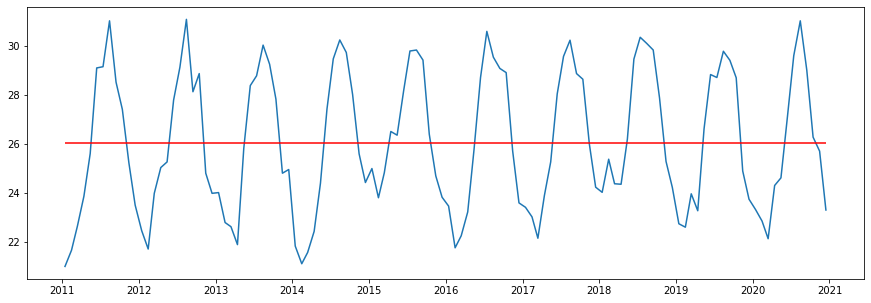

In [18]:
# Visualize chlorophll at lat/long over time
i = np.random.randint(0,t_s.shape[0])
sub = t.loc[(t.lat == t_s.lat.iloc[i]) & (t.lon == t_s.lon.iloc[i])].sort_values('date')

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(sub['date'], sub['sst'])
plt.hlines(y=sub.sst.mean(), xmin=sub.date.min(), xmax=sub.date.max(), color='red')
# print info and chart
print('index:', i)
print('location:', round(t_s.lat.iloc[i], 4), round(t_s.lon.iloc[i], 4))
plt.show()

## Map of temperature property

In [19]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# world_snip = gpd.clip(world, gp)

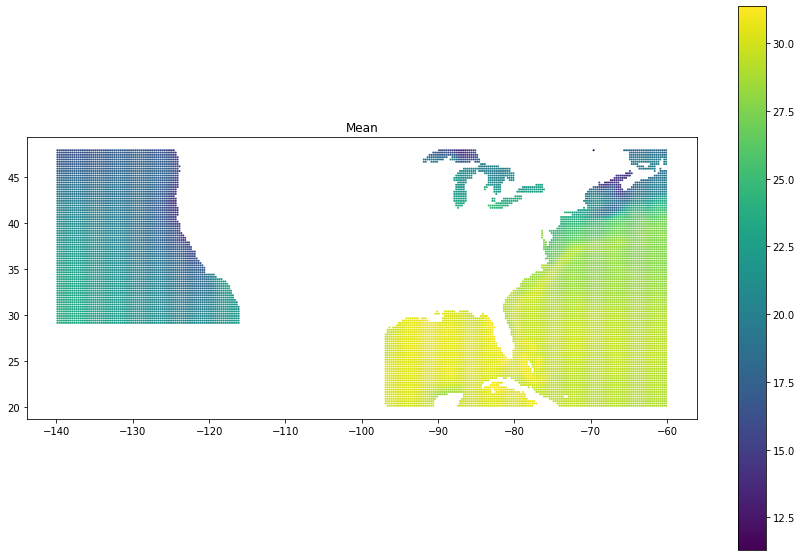

In [20]:
# Visualize
# temperature - pacific mean
geometry = [Point(xy) for xy in zip(t_s['lon'], t_s['lat'])]
gp = gpd.GeoDataFrame(t_s, crs=crs, geometry=geometry)

fig,ax = plt.subplots(figsize=(15,10))
gp.plot(ax=ax, column='max', markersize=1, legend=True)
plt.title('Mean')
plt.show()